In [1]:
from statsmodels.tsa.stattools import acf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from PyEMD import EMD

In [2]:
df = pd.read_csv('/content/solana-historical-data (4).csv', sep=',', header=0)

In [ ]:
df

,Дата,Открытие,Макс,Мин,Средняя,Закрыть,Изм.,Объём,Изм. Объема,Капитализ.,Изм. Капитализ.
1096,2022-06-09,$38.77,$41.59,$38.53,$39.70,39.90,2.91,"$845,083,513",NaN,"$13,641,597,977",NaN
1095,2022-06-10,$39.85,$40.64,$37.00,$38.63,37.04,-7.05,"$784,475,459",-7.17,"$12,663,454,413",-7.17
1094,2022-06-11,$37.06,$37.79,$33.38,$35.51,33.81,-8.76,"$711,719,673",-9.27,"$11,565,502,324",-8.67
1093,2022-06-12,$33.86,$34.18,$30.71,$32.36,30.71,-9.29,"$959,843,793",34.86,"$10,505,024,841",-9.17
1092,2022-06-13,$30.77,$30.86,$26.18,$28.95,27.97,-9.09,"$1,689,254,223",75.99,"$9,572,858,962",-8.87
...,...,...,...,...,...,...,...,...,...,...,...
4,2025-06-05,$153.33,$154.28,$142.32,$148.61,144.50,-5.76,"$3,351,802,624",70.89,"$75,733,219,718",-5.50
3,2025-06-06,$144.54,$151.85,$144.45,$147.25,148.15,2.50,"$2,008,109,466",-40.09,"$77,645,730,234",2.53
2,2025-06-07,$148.06,$152.65,$147.26,$149.50,150.05,1.35,"$1,386,025,930",-30.98,"$78,748,652,657",1.42
1,2025-06-08,$150.11,$154.85,$148.24,$151.44,152.55,1.63,"$1,357,439,380",-2.06,"$80,062,391,067",1.67


In [3]:
df['Дата'] = pd.to_datetime(df['Дата'])

In [4]:
df = df.sort_values(by='Дата', ascending=True)

In [5]:
df['Закрыть'] = df['Закрыть'].apply(lambda x: float(str(x).replace('$', '').strip()))


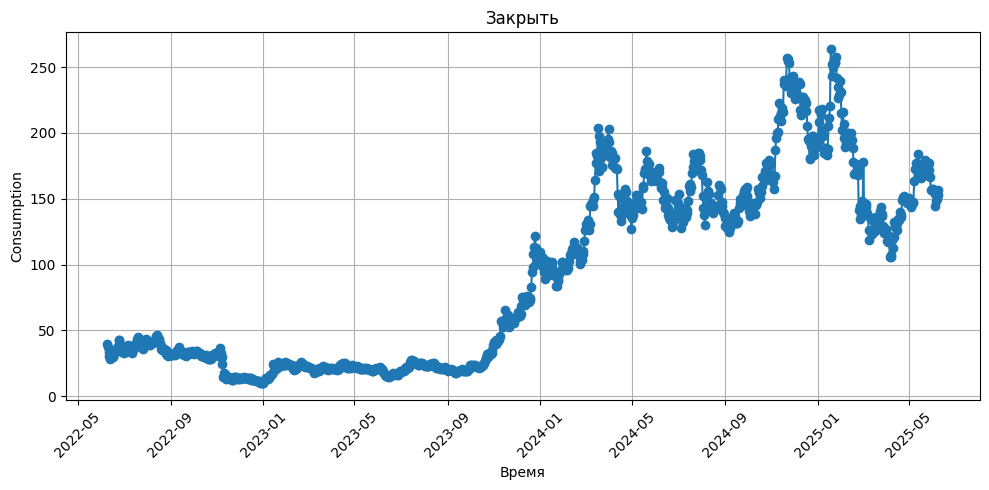

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(df['Дата'], df['Закрыть'], marker='o')
plt.title('Закрыть')
plt.xlabel('Время')
plt.ylabel('Consumption')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

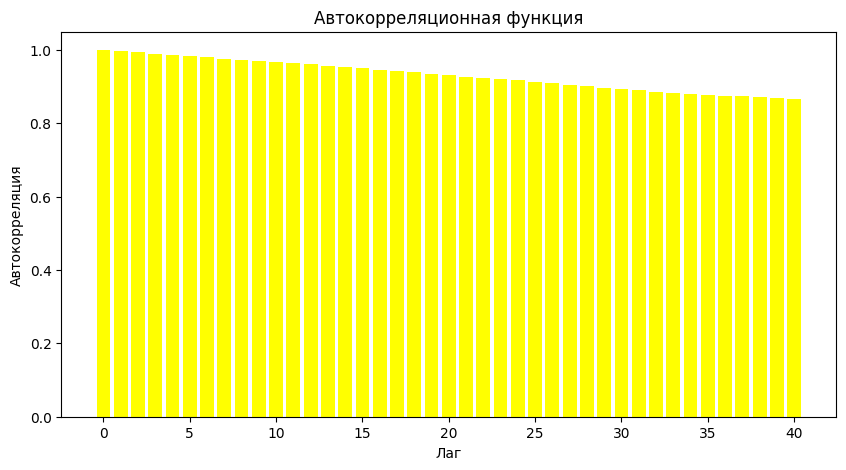

In [7]:
lags = 40  # Количество лагов для анализа
acf_values = acf(df['Закрыть'], nlags=lags)

# Визуализация
plt.figure(figsize=(10, 5))
plt.bar(range(lags + 1), acf_values, color='yellow')
plt.xlabel('Лаг')
plt.ylabel('Автокорреляция')
plt.title('Автокорреляционная функция')
plt.show()

# **Проверка на стационарность**

In [8]:
def test_stationarity(timeseries):
    print('Результаты теста Дики-Фуллера:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    if dfoutput['p-value'] <= 0.05:
        print("Ряд стационарен (отвергаем нулевую гипотезу)")
    else:
        print("Ряд нестационарен (не отвергаем нулевую гипотезу)")

In [9]:
print("До дифференцирования:")
test_stationarity(df['Закрыть'])

До дифференцирования:
Результаты теста Дики-Фуллера:
Test Statistic                   -1.134391
p-value                           0.701164
#Lags Used                        1.000000
Number of Observations Used    1095.000000
Critical Value (1%)              -3.436336
Critical Value (5%)              -2.864183
Critical Value (10%)             -2.568177
dtype: float64
Ряд нестационарен (не отвергаем нулевую гипотезу)


Приведение к стационарности

In [10]:
last_value = df['Закрыть'].iloc[0]

In [15]:
df['diff'] = df['Закрыть'].diff()
df.dropna(inplace=True)

In [16]:
df['diff']

,diff
1095,-2.86
1094,-3.23
1093,-3.10
1092,-2.74
1091,1.71
...,...
4,-8.86
3,3.65
2,1.90
1,2.50


In [17]:
#df['diff'] = df['Закрыть'].diff().fillna(0, inplace=True)
print("\nПосле первого дифференцирования:")
test_stationarity(df['diff'])


После первого дифференцирования:
Результаты теста Дики-Фуллера:
Test Statistic                  -34.630806
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1095.000000
Critical Value (1%)              -3.436336
Critical Value (5%)              -2.864183
Critical Value (10%)             -2.568177
dtype: float64
Ряд стационарен (отвергаем нулевую гипотезу)


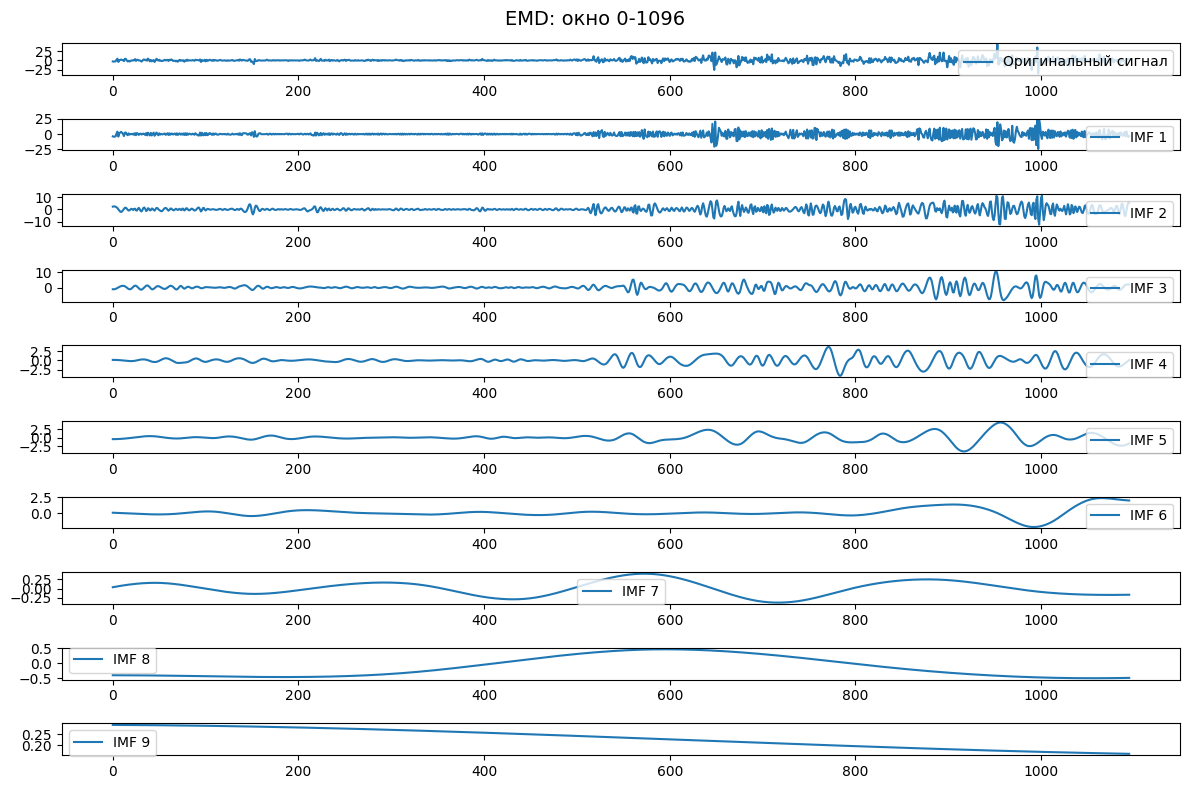

In [18]:
# Предположим, что Global_serius — это 1D-массив или Series
Global_serius = df['diff'].dropna().values
window_size = 5000  # количество точек в одном окне
step = 5000        # шаг окна, можно сделать меньше для перекрытия
total = len(Global_serius)
# Перебираем окна
for start in range(0, total, step):
    end = min(start + window_size, total)
    segment = Global_serius[start:end]

    emd = EMD()
    imfs = emd(segment)
    # Визуализация IMFs для текущего сегмента
    plt.figure(figsize=(12, 8))
    plt.suptitle(f'EMD: окно {start}-{end}', fontsize=14)
    plt.subplot(len(imfs) + 1, 1, 1)
    plt.plot(segment, label='Оригинальный сигнал')
    plt.legend()
    for i, imf in enumerate(imfs):
        plt.subplot(len(imfs) + 1, 1, i + 2)
        plt.plot(imf, label=f'IMF {i + 1}')
        plt.legend()
    plt.tight_layout()
    plt.show()
    break

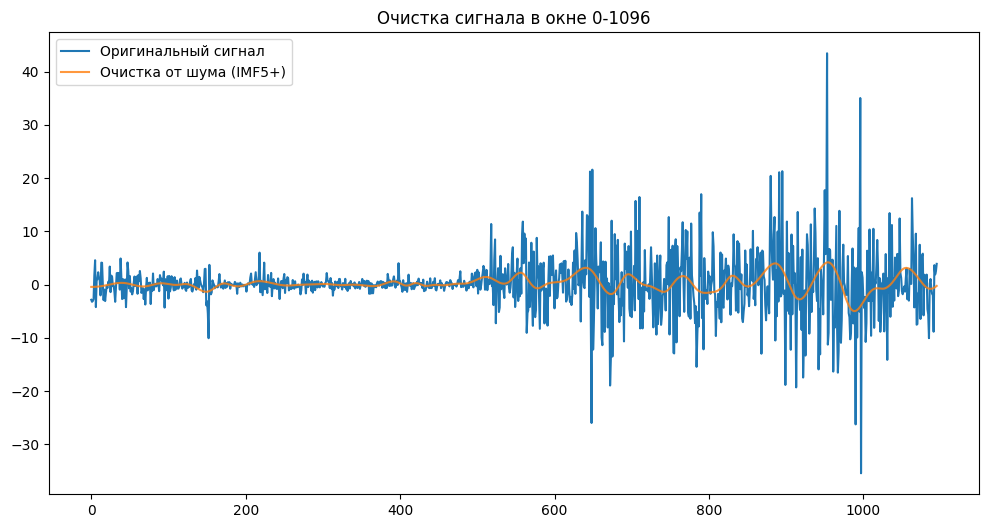

In [19]:
for start in range(0, total, step):
    end = min(start + window_size, total)
    segment = Global_serius[start:end]
    emd = EMD()
    imfs = emd(segment)
    # Проверка, что имфов достаточно
    if len(imfs) <= 4:
        continue  # мало компонент — пропускаем окно
    # Суммируем IMF5 и далее
    cleaned = np.sum(imfs[4:], axis=0)
    cleaned_series = pd.Series(cleaned)
    # Визуализация
    plt.figure(figsize=(12, 6))
    plt.plot(segment, label='Оригинальный сигнал')
    plt.plot(cleaned_series, label='Очистка от шума (IMF5+)', alpha=0.8)
    plt.title(f'Очистка сигнала в окне {start}-{end}')
    plt.legend()
    plt.show()
    break

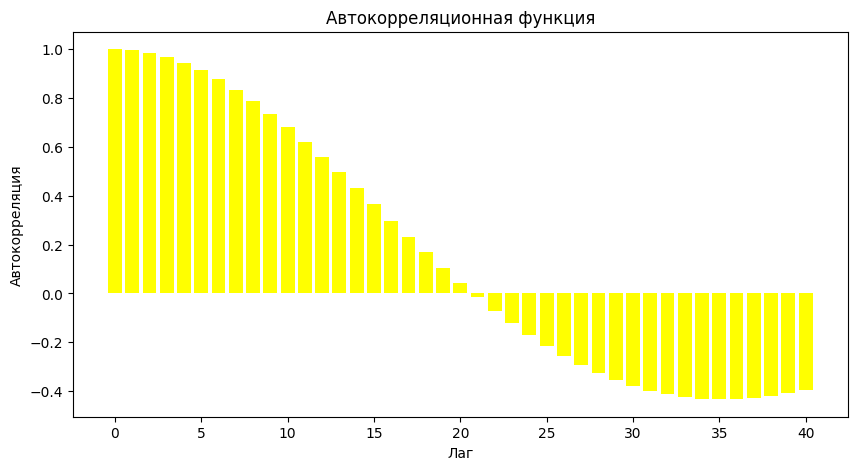

In [20]:
lags = 40  # Количество лагов для анализа
acf_values = acf(cleaned_series, nlags=lags)

# Визуализация
plt.figure(figsize=(10, 5))
plt.bar(range(lags + 1), acf_values, color='yellow')
plt.xlabel('Лаг')
plt.ylabel('Автокорреляция')
plt.title('Автокорреляционная функция')
plt.show()

# **Преобразование перед обучением**

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(cleaned_series.values.reshape(-1, 1))

In [22]:
# Формируем входные и выходные данные
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(scaled_data, seq_length)

In [23]:
train_size = int(len(X) * 0.8) # Например, 80% для обучения
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Форма X_train: {X_train.shape}") # (количество_тренировочных_образцов, sequence_length, 1)
print(f"Форма y_train: {y_train.shape}") # (количество_тренировочных_образцов,)
print(f"Форма X_test: {X_test.shape}")   # (количество_тестовых_образцов, sequence_length, 1)
print(f"Форма y_test: {y_test.shape}")   # (количество_тестовых_образцов,)

Форма X_train: (860, 20, 1)
Форма y_train: (860, 1)
Форма X_test: (216, 20, 1)
Форма y_test: (216, 1)


# **LSTM**

In [24]:
model_lstm = Sequential()

model_lstm.add(LSTM(50, activation='relu', return_sequences=True,
              input_shape=(seq_length, 1)))

model_lstm.add(LSTM(50, return_sequences=True))
model_lstm.add(LSTM(50))

model_lstm.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Компилируем модель
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

model_lstm.summary()
# Обучаем модель
model_lstm.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.1241 - val_loss: 0.0460
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0094 - val_loss: 0.0418
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0068 - val_loss: 0.0402
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0063 - val_loss: 0.0376
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0059 - val_loss: 0.0346
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0048 - val_loss: 0.0314
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0046 - val_loss: 0.0254
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0038 - val_loss: 0.0174
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0034 - val_loss: 0.0096
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0019 - val_loss: 0.0046


In [26]:
# Делаем прогноз
y_pred_lstm = model_lstm.predict(X_test)

# Возвращаем данные в исходный масштаб
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


In [28]:
# Для визуализации нам нужны значения в исходном диапазоне
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_lstm_original = scaler.inverse_transform(y_pred_lstm)

In [29]:
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))

In [ ]:
reconstructed = np.r_[last_value, last_value + np.cumsum(y_pred_lstm_original)]

In [27]:
# Сначала получаем индексы для всего X и y
full_y_indices = df.index[seq_length:]

# Теперь разделяем индексы так же, как X и y
train_indices = full_y_indices[:train_size]
test_indices = full_y_indices[train_size:]

In [33]:
residual = segment - np.sum(imfs, axis=0)
restored_signal = np.sum(imfs, axis=0) + residual

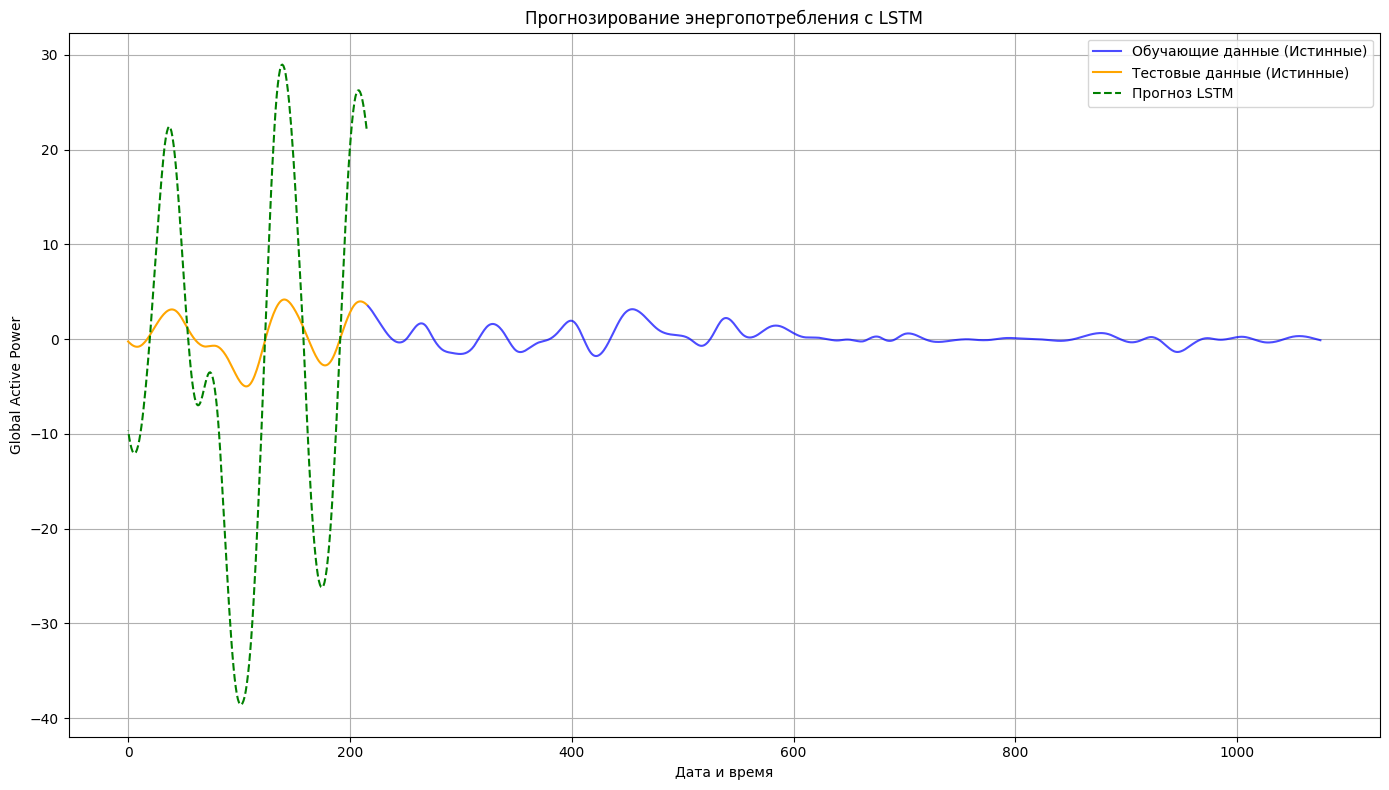

RMSE на тестовой выборке (в исходном масштабе): 16.9956


In [30]:
#Построение графика
plt.figure(figsize=(14, 8)) # Увеличенный размер для лучшей читаемости

plt.plot(train_indices, y_train_original, label='Обучающие данные (Истинные)', color='blue', alpha=0.7)

# График истинных тестовых данных
plt.plot(test_indices, y_test_original, label='Тестовые данные (Истинные)', color='orange')

# График предсказаний LSTM
plt.plot(test_indices, y_pred_lstm_original, label='Прогноз LSTM', color='green', linestyle='--')

plt.title('Прогнозирование энергопотребления с LSTM')
plt.xlabel('Дата и время')
plt.ylabel('Global Active Power')
plt.legend()
plt.grid(True)
plt.tight_layout() # Автоматическая настройка параметров графика для плотной компоновки
plt.show()

# Оценка RMSE на оригинальных данных
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_lstm_original))
print(f"RMSE на тестовой выборке (в исходном масштабе): {rmse:.4f}")

# GRU

In [35]:
model_gru = Sequential()

model_gru.add(GRU(50, activation='relu', return_sequences=True,
              input_shape=(seq_length, 1)))

model_gru.add(GRU(50, return_sequences=True))
model_gru.add(GRU(50))

model_gru.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
model_gru.compile(optimizer='adam', loss='mean_squared_error')

In [37]:
model_gru.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 0.1188 - val_loss: 0.0258
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0043 - val_loss: 0.0194
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0029 - val_loss: 0.0165
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0023 - val_loss: 0.0135
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0019 - val_loss: 0.0101
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0015 - val_loss: 0.0075
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0011 - val_loss: 0.0056
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 8.1059e-04 - val_loss: 0.0043
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 6.9435e-04 - val_loss: 0.0035
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 5.6172e-04 - val_loss: 0.0029
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 4.3253e-04 - val_loss: 0.0024
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/

In [38]:
y_pred_gru = model_gru.predict(X_test)

y_pred_gru = scaler.inverse_transform(y_pred_gru)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


In [39]:
y_pred_gru_original = scaler.inverse_transform(y_pred_gru)

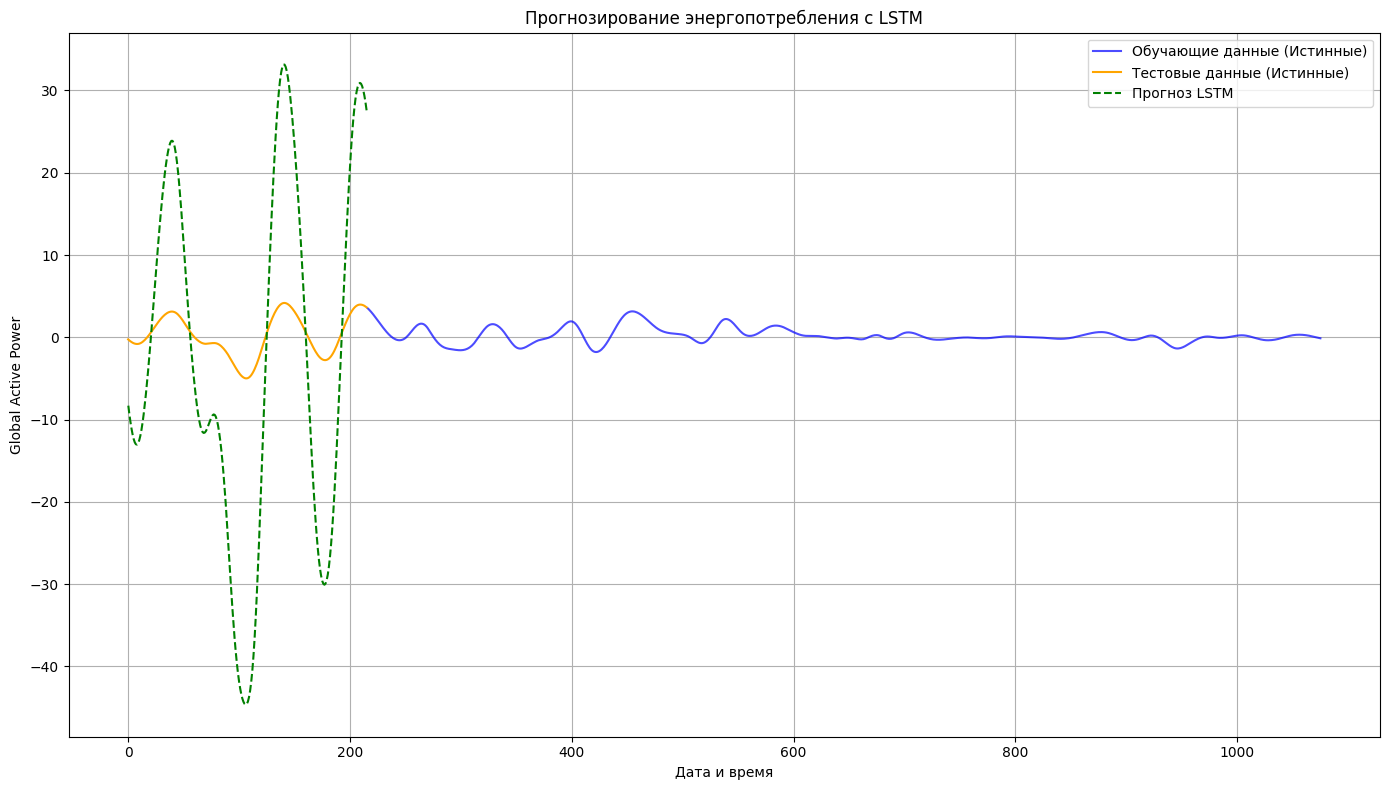

RMSE на тестовой выборке (в исходном масштабе): 19.8323


In [52]:
#Построение графика
plt.figure(figsize=(14, 8)) # Увеличенный размер для лучшей читаемости

plt.plot(train_indices, y_train_original, label='Обучающие данные (Истинные)', color='blue', alpha=0.7)

# График истинных тестовых данных
plt.plot(test_indices, y_test_original, label='Тестовые данные (Истинные)', color='orange')

# График предсказаний LSTM
plt.plot(test_indices, y_pred_gru_original, label='Прогноз LSTM', color='green', linestyle='--')

plt.title('Прогнозирование энергопотребления с LSTM')
plt.xlabel('Дата и время')
plt.ylabel('Global Active Power')
plt.legend()
plt.grid(True)
plt.tight_layout() # Автоматическая настройка параметров графика для плотной компоновки
plt.show()

# Оценка RMSE на оригинальных данных
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_gru_original))
print(f"RMSE на тестовой выборке (в исходном масштабе): {rmse:.4f}")

# ARIMA

In [53]:
train_size = int(len(cleaned_series) * 0.8)
train_data_arima, test_data_arima = cleaned_series[0:train_size], cleaned_series[train_size:]

In [54]:
arima_order = (1, 1, 1) # (p, d, q)
model = ARIMA(train_data_arima, order=arima_order)
model_fit = model.fit()

print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  876
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3342.636
Date:                Mon, 16 Jun 2025   AIC                          -6679.272
Time:                        13:23:12   BIC                          -6664.950
Sample:                             0   HQIC                         -6673.794
                                - 876                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9940      0.003    295.596      0.000       0.987       1.001
ma.L1          0.9950      0.011     92.987      0.000       0.974       1.016
sigma2      2.766e-05      1e-06     27.644      0.0

In [59]:
forecast_steps = len(test_data_arima)
forecast = model_fit.predict(start=len(test_data_arima), end=len(test_data_arima) + forecast_steps -1)

In [60]:
forecast = np.array(forecast)

In [61]:
forecast = forecast.reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)
#residual = segment - np.sum(imfs, axis=0)
#restored_signal = np.sum(imfs, axis=0) + residual

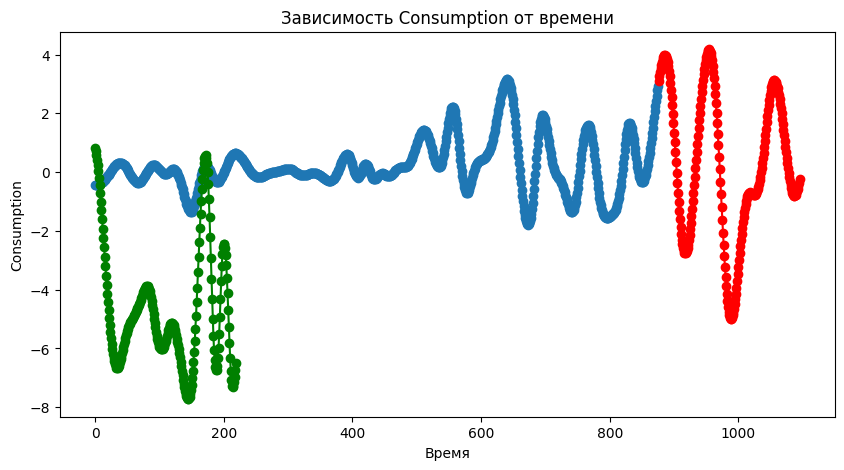

RMSE на тестовой выборке (в исходном масштабе): 5.4276


In [63]:
# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(train_data_arima, marker='o')
plt.plot(test_data_arima, marker='o', color='red', label='test')
plt.plot(forecast, marker='o', color='green', label='prediction')
plt.title('Зависимость Consumption от времени')
plt.xlabel('Время')
plt.ylabel('Consumption')
plt.show()

# Оценка RMSE на оригинальных данных
rmse = np.sqrt(mean_squared_error(test_data_arima, forecast))
print(f"RMSE на тестовой выборке (в исходном масштабе): {rmse:.4f}")